<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic11/Chollet_HFST11b_sequence_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

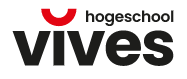<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



# 11. Deep learning for text: Bag-of-words vs. sequence models

Deze notebook bevat de codevoorbeelden (met aanvullende uitleg) uit het tweede deel van hoofdstuk 11 van het boek "Deep Learning with Python" (2e editie) van François Chollet, nl. paragraaf 11.3 over bag-of-words en sequence models.

## 11.3. Two approaches for representing groups of words: Sets and sequences

In natuurlijke talen is de **volgorde van woorden** relevant, maar niet zo strikt als bij tijdreeksen. Denk bijv. aan hoe je "een rode auto" in het Frans zegt: "une voiture rouge". In het Frans wordt het bijvoeglijk naamwoord inderdaad na het zelfstandig naamwoord gezet. Maar ook in het Nederlands kan je hetzelfde zeggen met verschillende zinnen die de woorden in een andere volgorde plaatsen. Bijv. "Ik blijf binnen omdat het regent." en "Het regent en daarom blijf ik binnen."

Er zijn 3 mogelijke oplossingen hiervoor:

1. de volgorde wordt genegeerd: dit zijn de traditionele **bag-of-words models** waarvan we er enkele in het vak Machine Learning hebben besproken (bv. logistic regression en naive Bayes);
2. de volgorde wordt bewaard zoals bij tijdreeksen en dan kunnen we **recurrente neurale netwerken** (RNNs) toepassen waarvan de bidirectional LSTM het meest aangewezen is voor NLP;
3. een hybride benadering zoals bij **transformers** waarbij de volgorde in rekening wordt gebracht maar niet zo strikt als bij RNNs.

Zowel RNNs als transformers zijn **sequence models** omdat ze de volgorde in rekening brengen.

Als voorbeeld gaan we de IMDB dataset met reviews classificeren op sentiment. We hebben dat al eerder gedaan, maar deze keer gaan we er dieper op ingaan, en we gaan deze keer ook de tekstdata preprocessen.

### Preparing the IMDB movie reviews data

We downloaden de originele dataset van Stanford University:

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  12.9M      0  0:00:06  0:00:06 --:--:-- 16.6M


De dataset heeft de volgende folderstructuur:

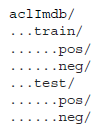

De "unsup" subfolder mag verwijderd worden:

In [ ]:
!rm -r aclImdb/train/unsup

Het is altijd een goed idee om de data te checken:

In [ ]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

Er is enkel een training- en testset, dus we maken een validatieset aan door 20% van de trainingsdata aan de kant te zetten in subfolder "val":

In [ ]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

Voilà, we zijn klaar om er Keras datasets van te maken mbv `text_dataset_from_directory`:

In [ ]:
from tensorflow import keras

batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Shapes en dtypes checken:

In [ ]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'Dissapointing action movie with an interesting premise: a young Mafia would-to-be killer (Chandler) must demonstrate to his boss that he is a good man for the service so he goes to California to take some lessons with a very known professional killer (Beluschi). First and most important task: to kill a young woman (Lee) that is a completely strange for all of them. But is she a easy target? The movie goes on and on based upon this principal idea but the result is just bad routine; even the weird twist at the end does not save the movie. Good performance by Chandler. I give this a 4 (four).', shape=(), dtype=string)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


We hebben ook het eerste sample uitgeprint. Dat is een negatieve review die label 0 krijgt.

### Processing words as a set: The bag-of-words approach

Laten we eerst eens de klassieke bag-of-words benadering toepassen waarin de woordvolgorde van geen belang is.

#### Single words (unigrams) with binary encoding

We starten met "word-level tokenization" en gebruiken hiervoor de `TextVectorization` layer. We limiteren de 'vocabulary' tot de 20 000 meest voorkomende woorden, wat in het geval van tekstclassificatie meestal een goeie keuze is. Waarom doen we dat? Omdat we anders woorden die maar 1 of 2 keer voorkomen mee nemen in de training, terwijl die waarschijnlijk geen nuttige informatie bevatten.

In [ ]:
from keras.layers import TextVectorization

text_vectorization = TextVectorization(
    max_tokens=20_000,  # limit the vocabulary to the 20 000 most frequent words
    output_mode="multi_hot",  # Encode the output tokens as multi-hot binary vectors
)
text_only_train_ds = train_ds.map(lambda x, y: x)  # Prepare a dataset that only yields raw text inputs (no labels)
text_vectorization.adapt(text_only_train_ds)  # Use that dataset to index the dataset vocabulary via the adapt method

# Prepare processed versions of our training, validation, and test dataset.
# Make sure to specify num_parallel_calls to leverage multiple CPU cores.
binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

De output checken van deze "binary unigram" datasets:

In [ ]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


Waarom spreken we hier van "binary unigram"? Unigram wil zeggen 1-gram of dus individuele woorden als tokens. Binary verwijst naar de **multi-hot encoding**, d.w.z. dat er wordt aangegeven via 1 of 0 of een woord uit de 'vocabulary' al dan niet voorkomt in een review. Dat wil dus zeggen dat elke sample wordt omgezet naar een binaire vector met lengte gelijk aan het aantal woorden in de 'vocabulary':

In [ ]:
len(inputs[0]) == len(text_vectorization.get_vocabulary())

True

We definiëren een model en stoppen dat in een functie `get_model` omdat we dit model zullen toepassen op alle experimenten die we in deze paragraaf zullen uitvoeren:

In [ ]:
from tensorflow import keras
from keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

Trainen en evalueren van het "binary unigram model" (dat kan met CPU omdat het een eenvoudig feedforward model is):

In [ ]:
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
# fit() laten gebruik maken van Dataset.cache():
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache
history = model.fit(binary_1gram_train_ds.cache(),
                    validation_data=binary_1gram_val_ds.cache(),
                    epochs=10,
                    callbacks=callbacks)

model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 9s 14ms/step - loss: 0.3958 - accuracy: 0.8355 - val_loss: 0.2956 - val_accuracy: 0.8846
Epoch 2/10
625/625 [======================

We hebben al direct een test accuracy van ongeveer 89%. Dat is zeker niet slecht aangezien dit een binaire classificatie is en een random classifier slechts 50% zou halen.

We definiëren een functie om vlot de evolutie van loss en nauwkeurigheid tijdens training en validatie te kunnen plotten:

In [ ]:
import matplotlib.pyplot as plt

def plot_result(history):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='training');
    ax1.plot(history.history['val_loss'], label='validation');
    ax1.set_title('loss');
    ax1.legend();
    ax1.grid();
    ax2.plot(history.history['accuracy'], label='training');
    ax2.plot(history.history['val_accuracy'], label='validation');
    ax2.set_title('accuracy');
    ax2.legend();
    ax2.grid();

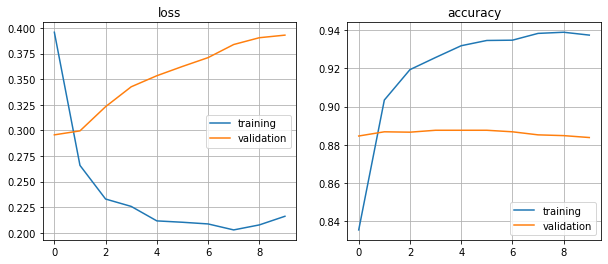

In [ ]:
plot_result(history)

We krijgen wel direct overfitting...

#### Bigrams with binary encoding

Een bag-of-words model houdt geen rekening met de woordvolgorde, maar door met N-grams te werken, kunnen we toch die volgorde een beetje in rekening brengen. Laten we eens uittesten of 'bigrams' als input van het neuraal netwerk een beter resultaat geven.

We moeten natuurlijk eerst weer de training-, validatie- en testset aanmaken:

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,  # default is ngrams 1 - hier nemen we dus 2
    max_tokens=20_000,  # opnieuw enkel de 20 000 meest voorkomende woorden gebruiken
    output_mode="multi_hot",  # multi-hot encoding toepassen
)
text_vectorization.adapt(text_only_train_ds)

binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Het "binary bigram model" trainen en evalueren:

In [ ]:
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
history = model.fit(binary_2gram_train_ds.cache(),
                    validation_data=binary_2gram_val_ds.cache(),
                    epochs=10,
                    callbacks=callbacks)

model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3877 - accuracy: 0.8381 - val_loss: 0.2912 - val_accuracy: 0.8876
Epoch 2/10
625/625 [======================

Bijna 90%, dus het is iets beter, wat wil zeggen dat 'lokale' woordvolgorde toch wel relevant is!

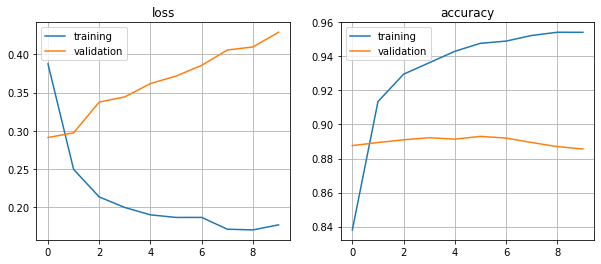

In [ ]:
plot_result(history)

#### Bigrams with TF-IDF encoding

We kunnen nog wat meer informatie uit die N-grams halen door te tellen hoeveel keer een N-gram voorkomt. In plaats van een binaire vector met nullen en enen wordt elk sampel dan omgezet naar een integer vector. Zo krijgen we een [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix).

Laten we het verschil illustreren met het voorbeeldje van de 'cat' zinnen. Eerst zetten we de zinnen om naar binaire vectoren mbv multi-hot encoding:

In [ ]:
import re  # regular expressions
import pandas as pd

# inputs
docs = ["The cat sat on the mat.",
        "The cat catches two mice."]

# standardization and tokenization
docs = [re.sub(r'[^\w\s]', '', doc.lower()).split() for doc in docs]
tokens = list(set([token for doc in docs for token in doc]))

# multi-hot encoding
multi_hot = pd.DataFrame([[int(token in doc) for token in tokens] for doc in docs])
multi_hot.columns = tokens
multi_hot

,on,cat,catches,two,mat,sat,the,mice
0,1,1,0,0,1,1,1,0
1,0,1,1,1,0,0,1,1


Als we nu het aantal keren dat een woord voorkomt tellen ipv enkel kijken of het voorkomt, dan krijgen we bij de eerste zin de waarde 2 bij het woord `"the"` ipv een 1:

In [ ]:
# counting
dtm = pd.DataFrame([[doc.count(token) for token in tokens] for doc in docs])
dtm.columns = tokens
dtm

,on,cat,catches,two,mat,sat,the,mice
0,1,1,0,0,1,1,2,0
1,0,1,1,1,0,0,1,1


Dit kunnen we natuurlijk sneller met de `TextVectorization` layer. In dat geval moeten we de `output_mode` op `"count"` zetten:

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="count"
)

Probleem bij die benadering is dat bepaalde woorden zoals lidwoorden en voorzetsels ('a', 'the', 'on', 'in', 'by', ...) veel voorkomen en toch niet zoveel informatie bevatten. We moeten dus **normalizeren**. We zouden elk aantal door het totaal aantal samples kunnen delen. Of we zouden kunnen standaardiseren door het gemiddelde aantal af te trekken en daarna te delen door de standaardafwijking. Maar het probleem hierbij is dat we heel veel nullen hebben in onze matrix. M.a.w. onze matrix is *'sparse'*. Daarom past men meestal **TF-IDF** normalisatie toe. Dat staat voor *'term frequency - inverse document frequency'*.

Uit het boek:

*The more a given term appears in a document, the more important that term is for
understanding what the document is about. At the same time, the frequency at which
the term appears across all documents in your dataset matters too: terms that
appear in almost every document (like “the” or “a”) aren’t particularly informative,
while terms that appear only in a small subset of all texts (like “Herzog”) are very distinctive,
and thus important. TF-IDF is a metric that uses these two ideas. It weights
a given term by taking “term frequency,” how many times the term appears in the
current document, and dividing it by a measure of “document frequency,” which estimates
how often the term comes up across the dataset. You’d compute it as follows:*

```python
import math
def tfidf(term, document, dataset):
    term_freq = document.count(term)
    doc_freq = math.log(sum([doc.count(term) for doc in dataset]) + 1)
    return term_freq / doc_freq
```

Je ziet dus dat het aantal keren dat een woord (token of term) voorkomt in een document (= "term frequency") wordt gedeeld door de logaritme van het aantal keren dat hetzelfde woord voorkomt in alle documenten (= "document frequency"). Bij dat aantal wordt 1 opgeteld om een soort van 'smoothing' toe te passen.

In ons voorbeeldje kunnen we de TF-IDF matrix eenvoudig berekenen adhv de document-term matrix met aantallen:

In [ ]:
import numpy as np
tfidf = dtm / np.log(dtm.sum(axis=0) + 1)
tfidf

,on,cat,catches,two,mat,sat,the,mice
0,1.442695,0.910239,0.000000,0.000000,1.442695,1.442695,1.442695,0.000000
1,0.000000,0.910239,1.442695,1.442695,0.000000,0.000000,0.721348,1.442695


Volgens [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) zijn er nog andere manieren om de TF-IDF te berekenen. Zo deelt men soms de TF term in de teller door het totaal aantal termen (woorden) in een document zodat het een echte frequentie is, en soms telt men nog eens 1 op bij de IDF in de noemer.

In Keras hoeven we ons daar allemaal geen zorgen over te maken als we de `TextVectorization` layer gebruiken. We moeten dan wel de `output_mode` op `tf_idf` zetten. Wie toch wil weten welke formule men in Keras toepast om de TF-IDF gewichten te berekenen, vindt de nodige uitleg in [dit artikel](https://linux-blog.anracom.com/2021/10/11/tf-idf-which-formula-to-take-in-combination-with-the-keras-tokenizer/).

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",  # TF-IDF encoding!
)

We doen verder met deze TF-IDF scores en dus maken we opnieuw een training-, validatie- en testset aan:

In [ ]:
text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

En we trainen en evalueren het "TF-IDF bigram" model:

In [ ]:
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
]

history = model.fit(tfidf_2gram_train_ds.cache(),
                    validation_data=tfidf_2gram_val_ds.cache(),
                    epochs=10,
                    callbacks=callbacks)

model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_6 (Dense)             (None, 16)                320016    
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 9s 14ms/step - loss: 0.4975 - accuracy: 0.7833 - val_loss: 0.3090 - val_accuracy: 0.8796
Epoch 2/10
625/625 [======================

In dit geval krijgen we geen beter resultaat, maar bij veel problemen van tekstclassificatie zorgt 'TF-IDF weighting' wel voor een verbetering van ongeveer een percent. Als we naar de overfitting kijken adhv de evolutie van de loss en de nauwkeurigheid tijdens trainen en valideren, dan zien we wel een kleine verbetering:

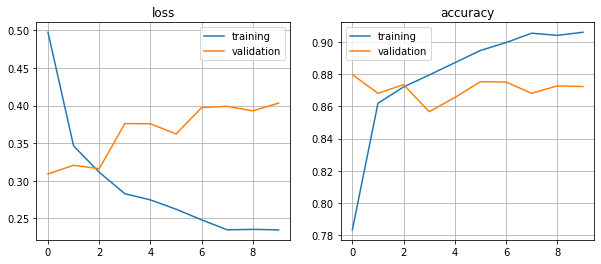

In [ ]:
plot_result(history)

#### Exporting a model that processes raw strings

Uit het boek:

*In the preceding examples, we did our text standardization, splitting, and indexing as
part of the tf.data pipeline. But if we want to export a standalone model independent
of this pipeline, we should make sure that it incorporates its own text preprocessing
(otherwise, you’d have to reimplement in the production environment, which
can be challenging or can lead to subtle discrepancies between the training data and
the production data). Thankfully, this is easy.
Just create a new model that reuses your TextVectorization layer and adds to it
the model you just trained:*

In [ ]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [ ]:
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

90.90 percent positive


### Processing words as a sequence: The sequence model approach

Woordvolgorde is dus belangrijk. Het probleem met het gebruik van N-grams is dat dit een vorm van manuele feature extraction is, terwijl we eigenlijk liever willen dat de neurale netwerken zelf de features gaan extraheren! Dus laten we de sequence modellen eens uitproberen die wél de volgorde van de woorden in rekening brengen.

Uit het boek:

*To implement a sequence model, you’d start by representing your input samples as
sequences of integer indices (one integer standing for one word). Then, you’d map
each integer to a vector to obtain vector sequences. Finally, you’d feed these
sequences of vectors into a stack of layers that could cross-correlate features from adjacent
vectors, such as a 1D convnet, a RNN, or a Transformer.*

Eerst proberen we de bidirectional LSTM uit, die we al kennen uit het vorige hoofdstuk! In 2016-2017 werd dit type model beschouwd als de state-of-the-art. Vandaag de dag zijn dat echter de transformers. Die komen later in dit hoofdstuk aan bod.

#### A first practical example

Zoals gezegd moeten we "integer sequence" datasets creëren voor training, validatie en evaluatie.

De data opnieuw downloaden:

In [ ]:
from shutil import rmtree
try: rmtree("aclImdb")  # voor het geval de aclImdb folder zou bestaan
except: pass
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  21.8M      0  0:00:03  0:00:03 --:--:-- 21.8M


De training-, validatie- en testset aanmaken:

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras

batch_size = 32

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))  # 20% voor validatie
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

# Prepare a dataset that only yields raw text inputs (no labels).
# Use that dataset to index the dataset vocabulary via the adapt() method (see below).
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Om te begrijpen wat het verschil is tussen `train_ds` en `text_only_train_ds` printen we de eerste sample van de eerste batch uit. Bij `train_ds` is er ook een target, bij `text_only_train_ds` niet:

In [ ]:
for sample, target in train_ds:
    print(sample[0])
    print(target[0])
    break

tf.Tensor(b'Well, on the endless quest for horror, we will come across this film, apparently re-released on DVD recently for some ungodly reason. The transfer is awful and the quality just sucks. I don\'t think this is due to a bad remaster or anything, I just think the film is poorly done.<br /><br />Obviously filmed at an abandoned school with a budget that was no doubt wasted on cheap beer and no talent hacks, "Slaughter High" starts out slow and doesn\'t pick up pace until about an hour in. First, we get to see a \'nerd\' as he is picked on by a group of...I actually don\'t even know what they were supposed to be...jocks? The ringleader, with his ultra hooknose is so ugly he should have definitely been cast as the nerd. Then, there is a \'big guy\' and a couple of dumb losers and chicks who are supposed to be \'hot\' but aren\'t. It\'s a mystery why this group of rejects is picking on one of their own, but I guess the viewer is to assume these are \'cool kids\' picking on a dweeb. 

In [ ]:
for sample in text_only_train_ds:
    print(sample[0])
    break

tf.Tensor(b"This was an excellent film. I don't understand why so many people don't like it. There was so much in it to connect with, so many beautiful images, and so much compassion in the things that weren't said. I was thoroughly entertained, and was left with a feeling of joyous exuberance, just as I am when I finish most any Tom Robbins story. Now I haven't read this particular book of Robbin's, so I don't now how this matched up, but I can't imagine this movie could have been a very bad interpretation. The movie left a lot for you to define yourself, which is the best part of any Tom Robbins novel, dreaming up the details. <br /><br />To all of you who said this was the worst movie ever, I pity what little must be left of the dimming light in your hearts. Far from the worst ever this movie was glorious. Long live the whooping crane.", shape=(), dtype=string)


De "integer sequence" datasets aanmaken mbv `TextVectorization`. Uit het boek:

*In order to keep a manageable
input size, we’ll truncate the
inputs after the first 600 words.
This is a reasonable choice, since
the average review length is 233
words, and only 5% of reviews
are longer than 600 words.*

In [ ]:
from keras import layers

max_length = 600
max_tokens = 20_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",  # we willen integer sequences
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)  # de dataset zonder labels!

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Ook hier checken we de eerste sample van de eerste batch in de trainingset:

In [ ]:
for sample, target in int_train_ds:
    print(sample[0])
    print(target[0])
    break

tf.Tensor(
[  106   282    36  8720   308     5     2   568   355    31   602   286
     8    40   400   703   488    93     5    32    62     3    31     2
   167    62  1873    11  1505    20  2058    10   232    10   216  4684
    11    19   417     2  2394  5476 14485   821    11   347    18  1069
  9375    44   204    76     4     1    31   201     3  1120  1350    19
     1   113   144    36  4635    26     4   114     5     2   527   241
   118    22     6   189   810    93    99   640    11    20     7     4
  3231     6     2   198    22    34  2397     9     7  1383     6    28
   161     3   105   380    36    10    26   537 13064    16     3  5915
     9  1038    17    70    12     9  2697   261    16   144     5   169
    36    26   108     1  1989   217   104    16     2   172  1999    15
  1607  2321  1687     1     3    79    45    23    26     2  1429  1256
    25  1441  2058 15395     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

We zien duidelijk dat de reeks is opgevuld met nullen om aan 600 elementen te komen.

Ons eerste 'sequence model' is een eenvoudig bidirectioneel LSTM waarbij we de integer sequences omzetten mbv one-hot encoding. Herinner je dat one-hot encoding een integer omzet naar een vector met allemaal nullen en een één op de positie van de integer. Laten we dat even checken:

In [ ]:
import tensorflow as tf

for sample, target in int_train_ds:
    print(tf.one_hot(sample[0], depth=max_tokens))
    break

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]], shape=(600, 20000), dtype=float32)


We krijgen dus inderdaad een 600 x 20000 matrix, waarbij elke rij overeenkomt met een element uit de integer sequence. In elke rij komt er exact één element voor dat gelijk is aan 1. In de laatste rijen komt 1 voor op de eerste positie om die rijen overeenkomen met de nullen die zijn toegevoegd aan de integer sequence, de zogenaamde 'padding'.

Laten we nu het model bouwen en compileren:

In [ ]:
import tensorflow as tf

inputs = keras.Input(shape=(None,), dtype="int64")   # One input is a sequence of integers
embedded = tf.one_hot(inputs, depth=max_tokens)      # One-hot encoding
x = layers.Bidirectional(layers.LSTM(32))(embedded)  # Add a bidirectional LSTM
x = layers.Dropout(0.5)(x)                           # dropout layer
outputs = layers.Dense(1, activation="sigmoid")(x)   # Finally, add a classification layer

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128448   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
___________________________________________________

Ons eerste basis "sequence model" kunnen we nu trainen mbv de code hieronder. Hiervoor heb je GPU nodig!

Uit het boek:

*This model trains very slowly, especially compared to the lightweight
model of the previous section. This is because our inputs are quite large: each
input sample is encoded as a matrix of size (600, 20000) (600 words per sample,
20,000 possible words). That’s 12,000,000 floats for a single movie review. Our bidirectional
LSTM has a lot of work to do!*

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds,
                    validation_data=int_val_ds,
                    epochs=10,
                    callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 179s 274ms/step - loss: 0.5312 - accuracy: 0.7492 - val_loss: 0.3463 - val_accuracy: 0.8680
Epoch 2/10
625/625 [==============================] - 171s 273ms/step - loss: 0.3458 - accuracy: 0.8779 - val_loss: 0.3442 - val_accuracy: 0.8736
Epoch 3/10
625/625 [==============================] - 171s 274ms/step - loss: 0.2749 - accuracy: 0.9056 - val_loss: 0.4172 - val_accuracy: 0.8640
Epoch 4/10
625/625 [==============================] - 171s 274ms/step - loss: 0.2339 - accuracy: 0.9191 - val_loss: 0.3960 - val_accuracy: 0.8788
Epoch 5/10
625/625 [==============================] - 171s 274ms/step - loss: 0.2032 - accuracy: 0.9308 - val_loss: 0.3286 - val_accuracy: 0.8828
Epoch 6/10
625/625 [==============================] - 172s 274ms/step - loss: 0.1839 - accuracy: 0.9404 - val_loss: 0.4512 - val_accuracy: 0.8840
Epoch 7/10
625/625 [==============================] - 171s 274ms/step - loss: 0.1594 - accuracy: 0.9475 - val_loss: 0.3701 -

De nauwkeurigheid die het model haalt op de testset is slechter dan die van onze vorige modellen en we zien ook dat er vrij snel overfitting optreedt:

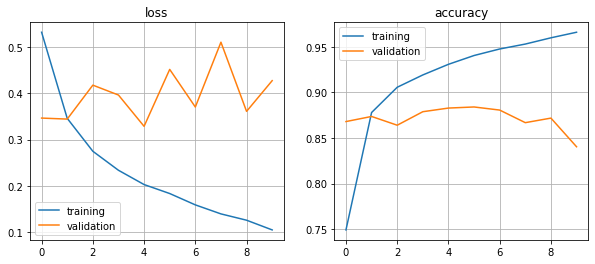

In [ ]:
plot_result(history)

One-hot encoding is hier geen goed idee - [word embedding](https://en.wikipedia.org/wiki/Word_embedding) is dat wel!

#### Understanding word embeddings

One-hot encoding toepassen betekent dat je er (impliciet) vanuit gaat dat de features (de woorden dus) onafhankelijk zijn van elkaar. Denk maar aan het 'naive Bayes' algoritme dat in we in het vak Machine Learning Fundamentals hebben besproken en waarbij we eveneens met binaire vectoren hebben gewerkt en dus diezelfde veronderstelling hebben gemaakt. Omdat die veronderstelling in werkelijkheid niet opgaat, noemen we dat algoritme 'naïef'.

Neem bijvoorbeeld de woorden 'film' en 'movie' die in het Engels dezelfde betekenis hebben en meestal door elkaar kunnen gebruikt worden. Als we dat in een afstandsmaat zouden willen uitdrukken, zoals de cosinusgelijkheid, dan zou de afstand tussen 'movie' en 'film' zeer klein moeten zijn, omdat die woorden qua betekenis zeer dicht bij elkaar liggen. Bij one-hot encoding staan ze wiskundig gezien echter loodrecht op elkaar, en liggen ze dus zeer ver van elkaar! Dat probleem wordt opgelost met **word embeddings**, die de betekenis van woorden op een correctere manier omzetten in wiskundige relaties.

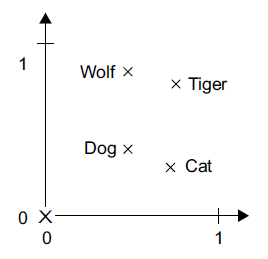

Het eenvoudig voorbeeldje in de figuur hierboven illustreert dit. Je ziet dat 'dog' en 'wolf' op een verticale lijn liggen omdat ze beiden 'hondachtigen' zijn, net zoals 'cat' en 'tiger' op een lijn liggen als 'katachtigen'. Op dezelfde manier liggen 'dog' en 'cat' ongeveer op dezelfde hoogte als 'huisdieren', net als 'wolf' en 'tiger' omdat het 'wilde dieren' zijn. 'Word embeddings' leren dat soort van relaties tussen woorden uit tekstdata en plaatsen de woorden meetkundig op een betekenisvolle manier zoals in het voorbeeldje: *Similar words get embedded in close
locations, and further, specific directions in the embedding space are meaningful.* Een ander klassiek voorbeeld is dat van 'koning' waarvan je de 'man' vector aftrekt en de 'vrouw' vector optelt om uit te komen bij 'koningin'.

Een tweede voordeel van 'word embeddings' is dat die resulteren in 'dense' arrays met minder dimensies dan de arrays die one-hot encoding oplevert. Bij one-hot encoding zijn de arrays bovendien 'sparse'; m.a.w. ze bevatten heel veel nullen.

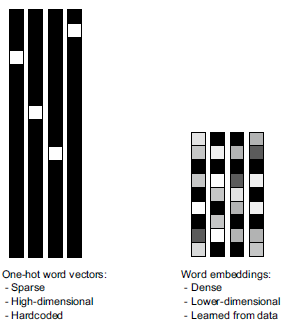

In tegenstelling tot one-hot encoding worden word embeddings dus geleerd uit tekstdata, wat uiteraard ook een voordeel is. Er zijn 2 manieren om word embeddings te verkrijgen:

1. *Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.*

2. *Load into your model word embeddings that were precomputed using a different machine learning task than the one you’re trying to solve. These are called* **pretrained word embeddings**.

#### Learning word embeddings with the `Embedding` layer

Omdat er verschillende natuurlijke talen zijn maar ook verschillende conteksten waarin die talen worden toegepast - een sentimentanalyse van reviews van films is bijv iets compleet anders dan juridische documenten classificeren - moeten we in principe voor elke specifieke NLP taak een nieuwe 'word embedding space' leren. In Keras kan dat eenvoudig met de `Embedding` layer! *This layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors. It takes integers as input, looks up these integers in an internal dictionary, and returns the associated vectors. It’s effectively
a dictionary lookup:*

> `word index -> Embedding layer -> corresponding word vector`

*The Embedding layer takes as input a rank-2 tensor of integers, of shape (batch_size, sequence_length), where each entry is a sequence of integers. The layer then returns a 3D floating-point tensor of shape (batch_size, sequence_length, embedding_
dimensionality):*

```python
# max_tokens = 20_000
embedding_layer = layers.Embedding(input_dim=max_tokens,  # sequence_length
                                   output_dim=256)  # embedding_dimensionality
```

*When you instantiate an Embedding layer, its weights (its internal dictionary of token vectors) are initially random, just as with any other layer. During training, these
word vectors are gradually adjusted via backpropagation, structuring the space into something the downstream model can exploit. Once fully trained, the embedding space will show a lot of structure — a kind of structure specialized for the specific problem for which you’re training your model.*

We trainen nu een 'Bidirectional LSTM' model met een `Embedding` layer die 'from scratch' wordt getraind:

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               73984     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
___________________________________________________

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_rnn.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_rnn.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 37s 59ms/step - loss: 0.1562 - accuracy: 0.9482 - val_loss: 0.3824 - val_accuracy: 0.8794
Epoch 2/10
625/625 [==============================] - 38s 61ms/step - loss: 0.1291 - accuracy: 0.9567 - val_loss: 0.3916 - val_accuracy: 0.8742
Epoch 3/10
625/625 [==============================] - 32s 51ms/step - loss: 0.1095 - accuracy: 0.9654 - val_loss: 0.3873 - val_accuracy: 0.8870
Epoch 4/10
625/625 [==============================] - 36s 57ms/step - loss: 0.0862 - accuracy: 0.9727 - val_loss: 0.4102 - val_accuracy: 0.8820
Epoch 5/10
625/625 [==============================] - 32s 51ms/step - loss: 0.0734 - accuracy: 0.9776 - val_loss: 0.4403 - val_accuracy: 0.8840
Epoch 6/10
625/625 [==============================] - 37s 59ms/step - loss: 0.0631 - accuracy: 0.9801 - val_loss: 0.4486 - val_accuracy: 0.8734
Epoch 7/10
625/625 [==============================] - 36s 57ms/step - loss: 0.0553 - accuracy: 0.9839 - val_loss: 0.4894 - val_accuracy:

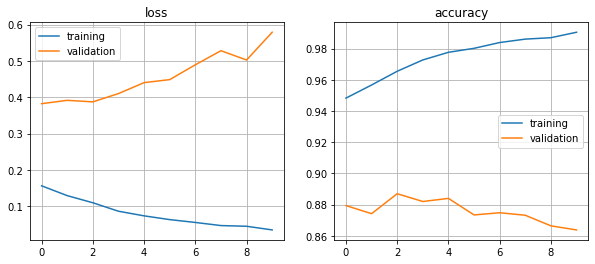

In [ ]:
plot_result(history)

Enkele vaststellingen:
- Het model traint veel sneller dan het LSTM model met one-hot encoded input.
- De nauwkeurigheid van het model voor de testset is vergelijkbaar of zelfs iets minder, wat deels te verklaren is doordat we de reviews hebben beperkt tot 600 woorden.
- We krijgen vrij snel overtraining.


#### Understanding padding and masking

Het beperken van de reviews tot 600 woorden is dus een probleem: reviews langer dan 600 woorden verliezen informatie, en omgekeerd worden reviews met minder dan 600 woorden opgevuld met nullen (= **padding**). Die nullen worden ook door het neurale netwerk verwerkt en dat is natuurlijk onnodig! Gelukkig kunnen we via de **masking** API het model duidelijk maken dat die nullen mogen overgeslagen worden!

*The Embedding layer is capable of generating a “mask” that corresponds to its
input data. This mask is a tensor of ones and zeros (or True/False booleans), of shape
(batch_size, sequence_length), where the entry `mask[i, t]` indicates where timestep
`t` of sample `i` should be skipped or not (the timestep will be skipped if `mask[i, t]`
is `0` or `False`, and processed otherwise).
By default, this option isn’t active — you can turn it on by passing `mask_zero=True`
to your Embedding layer. You can retrieve the mask with the `compute_mask()` method:*

In [ ]:
embedding_layer = layers.Embedding(input_dim=10, output_dim=256, mask_zero=True)
some_input = [[4, 3, 2, 1, 0, 0, 0],
              [5, 4, 3, 2, 1, 0, 0],
              [2, 1, 0, 0, 0, 0, 0]]
mask = embedding_layer.compute_mask(some_input)
mask

<tf.Tensor: shape=(3, 7), dtype=bool, numpy=
array([[ True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True, False, False],
       [ True,  True, False, False, False, False, False]])>

In praktijk moet je die masks gelukkig niet manueel berekenen en doet Keras dat voor jou. Laten we die optie nu eens uitproberen:

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)  # mask_zero = True!
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

Het model trainen en evalueren:

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_rnn_with_masking.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_rnn_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 41s 55ms/step - loss: 0.4054 - accuracy: 0.8181 - val_loss: 0.2998 - val_accuracy: 0.8782
Epoch 2/10
625/625 [==============================] - 36s 58ms/step - loss: 0.2298 - accuracy: 0.9104 - val_loss: 0.2611 - val_accuracy: 0.9016
Epoch 3/10
625/625 [==============================] - 35s 56ms/step - loss: 0.1662 - accuracy: 0.9377 - val_loss: 0.2943 - val_accuracy: 0.8854
Epoch 4/10
625/625 [==============================] - 33s 53ms/step - loss: 0.1227 - accuracy: 0.9564 - val_loss: 0.3150 - val_accuracy: 0.8920
Epoch 5/10
625/625 [==============================] - 33s 52ms/step - loss: 0.0929 - accuracy: 0.9667 - val_loss: 0.3430 - val_accuracy: 0.8880
Epoch 6/10
625/625 [==============================] - 34s 54ms/step - loss: 0.0669 - accuracy: 0.9777 - val_loss: 0.5141 - val_accuracy: 0.8622
Epoch 7/10
625/625 [==============================] - 38s 61ms/step - loss: 0.0494 - accuracy: 0.9844 - val_loss: 0.6236 - val_accuracy:

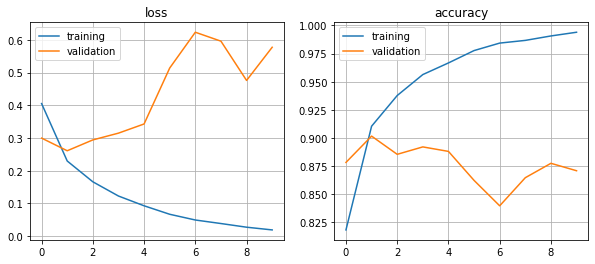

In [ ]:
plot_result(history)

We krijgen inderdaad een iets beter resultaat!

#### Using pretrained word embeddings

In plaats van zelf een 'word embedding space' af te leiden uit onze tekstdata, kunnen we ook een bestaande gebruiken, wat zeker interessant is als onze dataset klein is:

*The rationale behind using pretrained word embeddings in natural
language processing is much the same as for using pretrained convnets in image
classification: you don’t have enough data available to learn truly powerful features on
your own, but you expect that the features you need are fairly generic — that is, common
visual features or semantic features. In this case, it makes sense to reuse features
learned on a different problem.*

Er staan verschillende technieken om word embeddings te creëren, waarvan sommige gebruik maken van neurale netwerken en andere niet. Bekende pretrained word embeddings zijn:
- word2vec
- GloVe
- FastText
- ELMo

Dit YouTube filmpje legt kort uit hoe word embeddings zoals word2vec en ELMo werken: https://youtu.be/5MaWmXwxFNQ.

Hier gebruiken we GloVe, wat staat voor Global Vectors, en in 2014 is opgesteld aan Stanford University adhv de Engelstalige Wikipedia:

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-12-14 13:04:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-14 13:04:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-14 13:04:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Eerst moeten we de GloVe tekstfile parsen:

In [ ]:
import numpy as np

path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Nu kunnen we de GloVe word-embeddings matrix creëren. Die matrix heeft shape `(max_tokens, embedding_dim)`:

In [ ]:
embedding_dim = 100  # given by user

vocabulary = text_vectorization.get_vocabulary()  # Retrieve the vocabulary indexed by our previous TextVectorization layer
word_index = dict(zip(vocabulary, range(len(vocabulary))))  # Use it to create a mapping from words to their index in the vocabulary

embedding_matrix = np.zeros((max_tokens, embedding_dim))  # Initialize a matrix that we’ll fill with the GloVe vectors
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    # Fill entry i in the matrix with the word vector for index i.
    # Words not found in the embedding index will be all zeros.
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Tenslotte laden we de pretrained embeddings in een `Embedding` layer waarbij we gebruik maken van een `Constant` initializer:

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,  # op False zetten want de laag mag niet mee getraind worden!
    mask_zero=True,
)

Uiteraard zetten we de laag niet op `trainable` want ze mag niet worden mee getraind!

We kunnen de gecreëerde `Embedding` layer met de GloVe vectoren nu eenvoudig aan ons model toevoegen:

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
____________________________________________

Het model trainen en evalueren:

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 45s 59ms/step - loss: 0.5756 - accuracy: 0.6916 - val_loss: 0.4967 - val_accuracy: 0.7606
Epoch 2/10
625/625 [==============================] - 39s 62ms/step - loss: 0.4510 - accuracy: 0.7947 - val_loss: 0.4033 - val_accuracy: 0.8188
Epoch 3/10
625/625 [==============================] - 34s 54ms/step - loss: 0.3978 - accuracy: 0.8246 - val_loss: 0.4163 - val_accuracy: 0.8182
Epoch 4/10
625/625 [==============================] - 34s 55ms/step - loss: 0.3665 - accuracy: 0.8438 - val_loss: 0.3587 - val_accuracy: 0.8428
Epoch 5/10
625/625 [==============================] - 35s 57ms/step - loss: 0.3399 - accuracy: 0.8561 - val_loss: 0.3424 - val_accuracy: 0.8468
Epoch 6/10
625/625 [==============================] - 36s 57ms/step - loss: 0.3207 - accuracy: 0.8669 - val_loss: 0.3528 - val_accuracy: 0.8550
Epoch 7/10
625/625 [==============================] - 34s 54ms/step - loss: 0.3024 - accuracy: 0.8776 - val_loss: 0.3754 - val_accuracy:

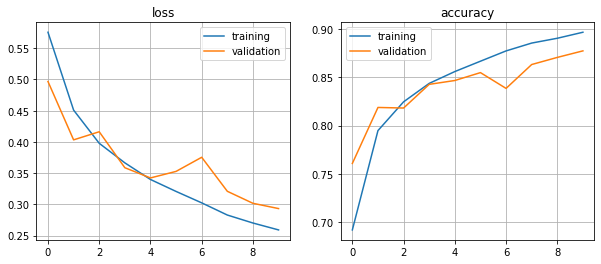

In [ ]:
plot_result(history)

We krijgen hier niet echt een beter resultaat omdat onze dataset groot genoeg is om zelf de word embeddings te leren zoals we eerder hebben gedaan. Maar bij kleine datasets zijn pretrained word embeddings wel zeer nuttig!

---